In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [86]:
#  pip install --upgrade scipy networkx

# 1. Data

In [2]:
hero_net = pd.read_csv(r"C:\Users\Marina\OneDrive\Desktop\archive\hero-network.csv")
edges = pd.read_csv(r"C:\Users\Marina\OneDrive\Desktop\archive\edges.csv")
nodes = pd.read_csv(r"C:\Users\Marina\OneDrive\Desktop\archive\nodes.csv")

In [88]:
hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE /
574464,CALLISTO,CALIBAN/
574465,CALIBAN/,ROGUE /


In [89]:
edges

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


In [90]:
nodes.shape

(19090, 2)

In [91]:
n_comics = nodes[nodes.type == 'comic'].count()
n_heros = nodes[nodes.type == 'hero'].count()
print(n_comics, n_heros)

node    12651
type    12651
dtype: int64 node    6439
type    6439
dtype: int64


## 1.1 Pre-processing 

In [3]:
hero_net["hero1"] = hero_net["hero1"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)
hero_net["hero2"] = hero_net["hero2"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [93]:
hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE


In [94]:
edges

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


In [4]:
edges["hero"] = edges["hero"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [5]:
hero = set(edges.hero)
hero_union = set(hero_net.hero1).union(set(hero_net.hero2))

diff = hero_union - hero.intersection(hero_union)
diff

{'SPIDER-MAN/PETER PAR'}

In [6]:
def jaccard_similarity(setA, setB):
    ''' 
    This function simply computes the Jaccard similarity from its definition.
    '''
    return len(set(setA).intersection(setB))/len(set(setA).union(setB))

In [7]:
for hero in set(edges.hero):
    for elem in diff:
        sim = jaccard_similarity(set(elem), set(hero))
        if sim >= 0.5:
            hero_net = hero_net.replace(elem, hero)

hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE


In [8]:
# test
hero = set(edges.hero)
hero_union = set(hero_net.hero1).union(set(hero_net.hero2))

diff = hero_union - hero.intersection(hero_union)
diff

set()

In [9]:
print(len(hero_union), len(hero.intersection(hero_union))) # all heroes' names in 'hero-network.csv' are now found in 'edges.csv'

6420 6420


## 1.2 First graph

In [30]:
G1 = nx.MultiGraph()

In [31]:
hero_net.apply(lambda row: G1.add_edge(row['hero1'], row['hero2']), axis=1)

0          0
1          0
2          0
3          1
4          1
          ..
574462    27
574463    22
574464     8
574465    11
574466     1
Length: 574467, dtype: int64

In [32]:
#drop sefl-loops
G1.remove_edges_from(nx.selfloop_edges(G1))

In [65]:
dicOfWeights = {}
for h1,h2 in hero_net.to_numpy():
    if h1 != h2:
        if (h1,h2) in dicOfWeights:
            dicOfWeights[(h1,h2)] += 1
        else:
            dicOfWeights[(h1,h2)] = 1


In [66]:
G1_weighted = nx.MultiGraph()

In [67]:
i = 0
for edge in list(G1.edges()):
    try:
        G1_weighted.add_edge(edge[0], edge[1], weight = 1/dicOfWeights[edge])
    except:
        G1_weighted.add_edge(edge[0], edge[1], weight = 1/dicOfWeights[(edge[1], edge[0])])


In [71]:
edges, weights = zip(*nx.get_edge_attributes(G1_weighted, 'weight').items())
for i in range(10):
    print((edges[i], weights[i]))

(('LITTLE, ABNER', 'PRINCESS ZANDA', 0), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 1), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 2), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 3), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 4), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 5), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 6), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 7), 0.2)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 0), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 1), 0.25)


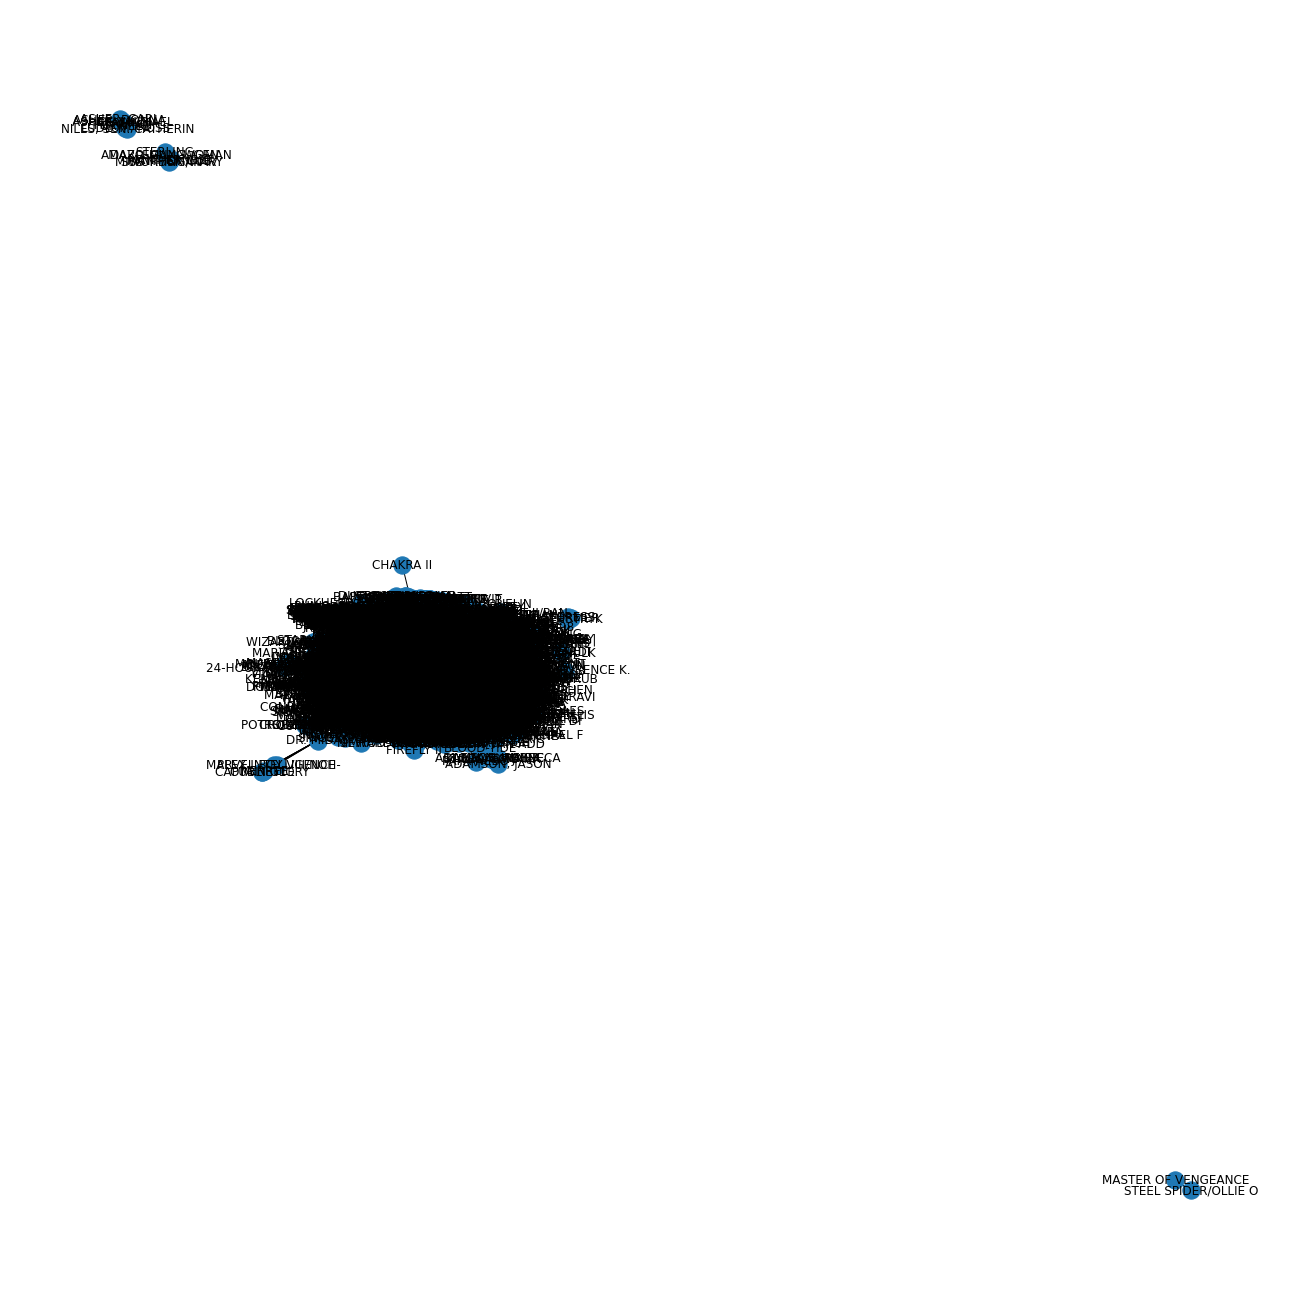

In [72]:
fig = plt.figure(figsize=(18,18))
nx.draw(G1_weighted, with_labels=True,node_size=300)
plt.show()

## 1.3 Second graph

In [67]:
attributes = nodes.set_index('node').to_dict('index')
attributes

{'2001 10': {'type': 'comic'},
 '2001 8': {'type': 'comic'},
 '2001 9': {'type': 'comic'},
 '24-HOUR MAN/EMMANUEL': {'type': 'hero'},
 '3-D MAN/CHARLES CHAN': {'type': 'hero'},
 '4-D MAN/MERCURIO': {'type': 'hero'},
 '8-BALL/': {'type': 'hero'},
 "A '00": {'type': 'comic'},
 "A '01": {'type': 'comic'},
 'A 100': {'type': 'comic'},
 'A 101': {'type': 'comic'},
 'A 102': {'type': 'comic'},
 'A 103': {'type': 'comic'},
 'A 104': {'type': 'comic'},
 'A 105': {'type': 'comic'},
 'A 106': {'type': 'comic'},
 'A 107': {'type': 'comic'},
 'A 108': {'type': 'comic'},
 'A 109': {'type': 'comic'},
 'A 10': {'type': 'comic'},
 'A 110': {'type': 'comic'},
 'A 111': {'type': 'comic'},
 'A 112': {'type': 'comic'},
 'A 113': {'type': 'comic'},
 'A 114': {'type': 'comic'},
 'A 115': {'type': 'comic'},
 'A 116': {'type': 'comic'},
 'A 117': {'type': 'comic'},
 'A 118': {'type': 'comic'},
 'A 119': {'type': 'comic'},
 'A 11': {'type': 'comic'},
 'A 120': {'type': 'comic'},
 'A 121': {'type': 'comic'},
 '

In [68]:
G2 = nx.from_pandas_edgelist(edges, 'hero', 'comic')
nx.set_node_attributes(G2, attributes)

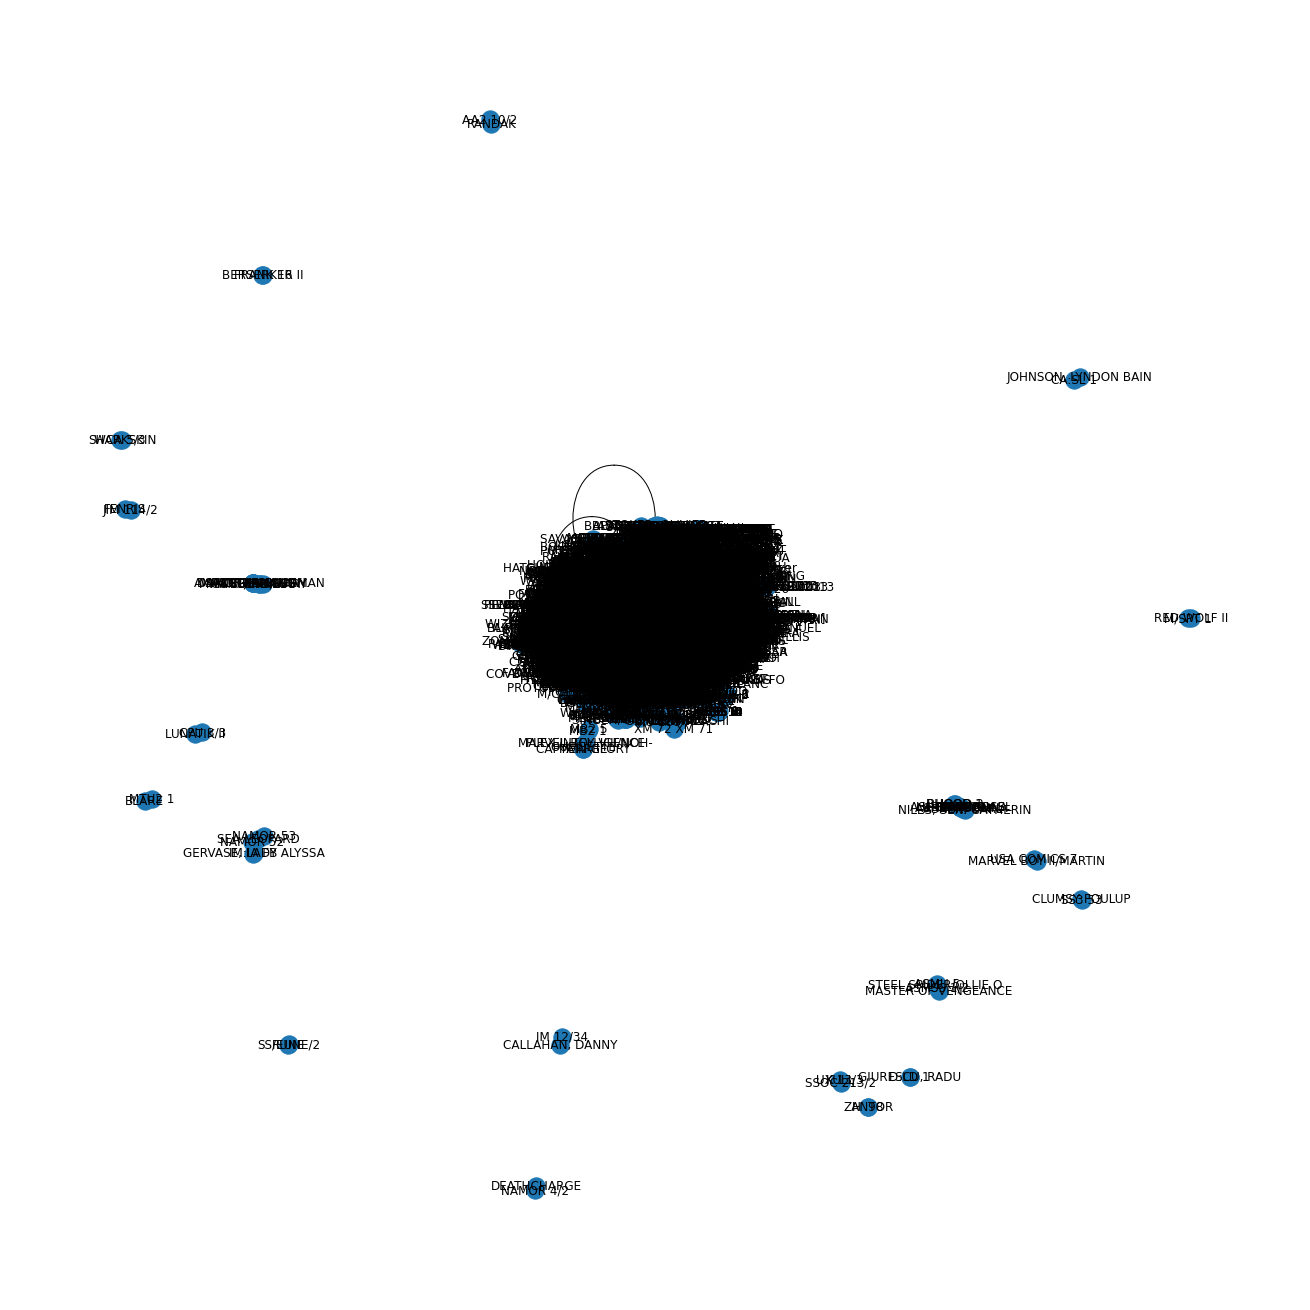

In [58]:
fig = plt.figure(figsize=(18,18))
nx.draw(G2, with_labels=True,node_size=300)
plt.show()

# 2. Backend Implementation

## Functionality 1 - extract the graph's features

In [50]:
n_nodes = int(G1.number_of_nodes())
print("Total number of nodes: ", n_nodes)
n_edges = int(G1.number_of_edges())
print("Total number of edges: ", n_edges)

Total number of nodes:  6420
Total number of edges:  572235


In [51]:
print("Degree for all nodes: ", list(G1.degree())[:20])

Degree for all nodes:  [('LITTLE, ABNER', 44), ('PRINCESS ZANDA', 30), ("BLACK PANTHER/T'CHAL", 3671), ('STEELE, SIMON/WOLFGA', 21), ('FORTUNE, DOMINIC', 37), ('ERWIN, CLYTEMNESTRA', 186), ('IRON MAN/TONY STARK', 11817), ('IRON MAN IV/JAMES R.', 2182), ('RAVEN, SABBATH II/EL', 26), ('CARNIVORE/COUNT ANDR', 121), ('GHOST', 66), ('ZIMMER, ABE', 232), ('FU MANCHU', 217), ('TARR, BLACK JACK', 436), ('SMITH, SIR DENIS NAY', 377), ('SHANG-CHI', 741), ('STARSHINE II/BRANDY', 550), ('ROM, SPACEKNIGHT', 676), ('MAN-THING/THEODORE T', 401), ('WU, LEIKO', 406)]


In [35]:
print("Total number of self-loops: ", int(nx.number_of_selfloops(G1)))
print("List of all nodes with self-loops: ",
             list(nx.nodes_with_selfloops(G1)))

Total number of self-loops:  0
List of all nodes with self-loops:  []


In [36]:
print("List of all nodes we can go to in a single step from some node: ",
                                                 list(G1.neighbors('LITTLE, ABNER')))

List of all nodes we can go to in a single step from some node:  ['PRINCESS ZANDA', "BLACK PANTHER/T'CHAL", 'CARNIVORE/COUNT ANDR', 'IRON MAN/TONY STARK', 'GOLDEN-BLADE', 'DIXON, GENERAL', 'IRON MAN IV/JAMES R.', 'JOCASTA', 'FUJIKAWA, RUMIKO', 'MADAME MENACE/SUNSET', 'JACOBS, GLENDA', 'WAR MACHINE II/PARNE', 'SAPPER', 'HOGAN, VIRGINIA PEPP', 'BINARY/CAROL DANVERS', 'FIN FANG FOOM/MIDGAR', 'MANN, DR. J. VERNON', 'THOR/DR. DONALD BLAK', 'TEMPEST II/NICOLETTE', 'JARVIS, EDWIN', 'INFERNO III/SAMANTHA', 'DECAY II/YOSHIRO HAC']


In [37]:
hero_net['hero1'].value_counts()

CAPTAIN AMERICA         8149
FAMINE/AUTUMN ROLFSO    6828
IRON MAN/TONY STARK     5850
THOR/DR. DONALD BLAK    5712
THING/BENJAMIN J. GR    5369
                        ... 
RAZORFIST IV/MARCO S       1
MARISTA                    1
THANADEMOS                 1
JONES, PHILLIP             1
SEAWEED MAN                1
Name: hero1, Length: 6205, dtype: int64

In [38]:
hero_net['hero2'].value_counts()

CAPTAIN AMERICA         8350
FAMINE/AUTUMN ROLFSO    7193
IRON MAN/TONY STARK     5967
THOR/DR. DONALD BLAK    5715
THING/BENJAMIN J. GR    5312
                        ... 
SHADOWCASTER               1
MAGOG                      1
SANDERS, MAC               1
KREIGKOPH, GEN.            1
MARKS, DR. SHIELA          1
Name: hero2, Length: 6168, dtype: int64

## Functionality 4 - Disconnecting Graphs (da rivedere/continuare)

Input:

- The graph data
- heroA: a superhero to which will relate sub-graph G_a
- heroB: a superhero to which will relate sub-graph G_b
- N: denoting the top N heroes that their data should be considered


Output:

- The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G_a and G_b.

In [69]:
print(nx.is_connected(G1))
print(nx.is_connected(G2))

False
False


In [14]:
# nx.connected_components gets the list of components,
# max() command returns the largest one
components = nx.connected_components(G1)
largest_component = max(components, key=len)

In [16]:
# returns neighbors
sorted(list(G1.neighbors('JOCASTA')))[:10]

['3-D MAN/CHARLES CHAN',
 'AJAK/TECUMOTZIN [ETE',
 'ANGEL/WARREN KENNETH',
 'ANT-MAN II/SCOTT HAR',
 'ANT-MAN/DR. HENRY J.',
 'ANTOINETTE, MARIE',
 'ARABIAN KNIGHT/ABDUL',
 'ARBOGAST, BAMBI',
 'ASTROVIK, NORMA',
 'ATTUMA']

In [105]:
# returns all nodes reachable from source in G
sorted(list(nx.descendants(G1, 'JOCASTA')))[:10]

['24-HOUR MAN/EMMANUEL',
 '3-D MAN/CHARLES CHAN',
 '4-D MAN/MERCURIO',
 '8-BALL',
 'A',
 "A'YIN",
 'ABBOTT, JACK',
 'ABCISSA',
 'ABEL',
 'ABOMINATION | MUTANT']

In [15]:
# add N
def disconneting_graphs(G, heroA, heroB):
    G_a = []
    G_b = []

    for edge in list(G.edges()):
        if heroA in edge:
            G_a.append(edge)

    for edge in list(G.edges()):
        if heroB in edge:
            G_b.append(edge)

    return G_a, G_b, len(G_a) + len(G_b)

In [17]:
G_a, G_b, result = disconneting_graphs(G1, 'JOCASTA', '8-BALL')
print(result)

760


In [102]:
newG1 = G1.copy()
newG1.remove_edges_from(G_a)
newG1.remove_edges_from(G_b)

In [108]:
G1.number_of_edges() - newG1.number_of_edges()

760

In [106]:
print(len(list(newG1.neighbors('JOCASTA'))))
print(len(list(newG1.neighbors('8-BALL'))))


0
0
